# Retention Time Prediction


This notebook is prepared to be run in Google [Colaboratory](https://colab.research.google.com/). In order to train the model faster, please change the runtime of Colab to use Hardware Accelerator, either GPU or TPU.

This notebook presents a short analysis of the Loss functions task where we  train the model with different Loss functions and analyze the results to decide which loss function works best with such a task.

In [2]:
# install the dlpro package in the current environment using pip

!python -m pip install -q git+https://github.com/wilhelm-lab/dlomix.git

The available modules in the framework are as follows:

In [3]:
import numpy as np
import pandas as pd
import dlomix

## 1. Load Data and Training

### Learning Rate
Similar to the initial notebook we will initialize our model and train it.
Use train_model method with different learning rates and check which learning rate would be the best to work with our dataset.

In [4]:
from dlomix.models.base import RetentionTimePredictor
import tensorflow as tf
from dlomix.eval.rt_eval import TimeDeltaMetric
from dlomix.data.RetentionTimeDataset import RetentionTimeDataset

In [11]:
def intialize_train_model(data_path):
  rtdata = RetentionTimeDataset(data_source=data_path,
                              seq_length=30, batch_size=64, val_ratio=0.2, test=False)
  model = RetentionTimePredictor(seq_length=30)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,decay=1e-7)

  # compile the model  with the optimizer and the metrics we want to use, we can add our customer delta95 metric

  model.compile(optimizer=optimizer, 
                loss='mse',
                metrics=['mean_absolute_error', TimeDeltaMetric(rtdata.data_mean, rtdata.data_std)])
  history = model.fit(rtdata.train_data,
                    validation_data=rtdata.val_data,
                    epochs=15)
  return model, history

In [6]:
TRAIN_DATAPATH_A = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix-resources/main/example_dataset/split_a/proteomTools_train_val_a.csv'
TRAIN_DATAPATH_B = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix-resources/main/example_dataset/split_b/proteomTools_train_val_b.csv'

TEST_DATAPATH_A = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix-resources/main/example_dataset/split_a/proteomTools_test_a.csv'
TEST_DATAPATH_B = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix-resources/main/example_dataset/split_b/proteomTools_test_b.csv'

In [12]:
data_splits_history = []
data_splits_models = []

print('train with split a')
m1, h1 = intialize_train_model(TRAIN_DATAPATH_A)
data_splits_history.append(h1)
data_splits_models.append(m1)

print('\n')
print('train with split b')
m2, h2 = intialize_train_model(TRAIN_DATAPATH_B)
data_splits_history.append(h2)
data_splits_models.append(m2)

train with split a
Epoch 1/15
398/398 [==============================] - 10s 22ms/step - loss: 1965.1569 - mean_absolute_error: 34.6943 - timedelta: 34.1642 - val_loss: 490.3186 - val_mean_absolute_error: 17.8240 - val_timedelta: 16.5785
Epoch 2/15
398/398 [==============================] - 9s 22ms/step - loss: 300.8969 - mean_absolute_error: 13.3978 - timedelta: 13.9743 - val_loss: 199.8465 - val_mean_absolute_error: 10.5683 - val_timedelta: 10.3030
Epoch 3/15
398/398 [==============================] - 9s 22ms/step - loss: 174.0308 - mean_absolute_error: 9.8437 - timedelta: 10.7221 - val_loss: 154.8997 - val_mean_absolute_error: 9.0572 - val_timedelta: 8.8899
Epoch 4/15
398/398 [==============================] - 9s 22ms/step - loss: 150.0511 - mean_absolute_error: 9.0183 - timedelta: 9.7775 - val_loss: 143.2446 - val_mean_absolute_error: 8.6424 - val_timedelta: 8.3837
Epoch 5/15
398/398 [==============================] - 9s 22ms/step - loss: 140.8932 - mean_absolute_error: 8.6795 - ti

## 2. Analysis

### A. Training and Validation

In [13]:
from dlomix.reports.RetentionTimeReport import RetentionTimeReport

#### Data Split A



In [41]:
report_a = RetentionTimeReport(output_path="./output", history=h1)

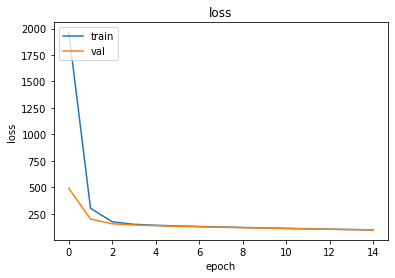

In [15]:
report_a.plot_keras_metric("loss")

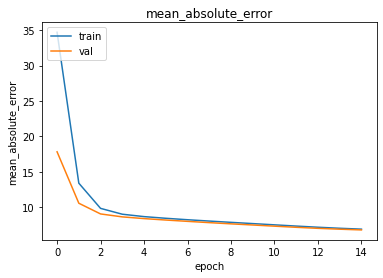

In [16]:
report_a.plot_keras_metric("mean_absolute_error")

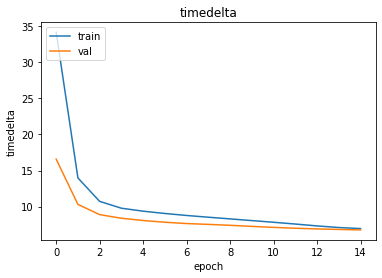

In [17]:
report_a.plot_keras_metric("timedelta")

#### Data Split B



In [59]:
report_b = RetentionTimeReport(output_path="./output", history=h2)

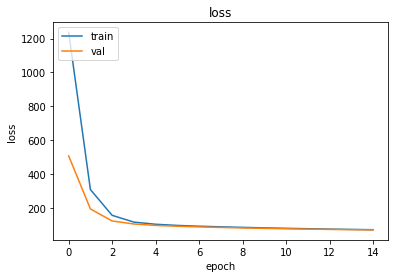

In [19]:
report_b.plot_keras_metric("loss")

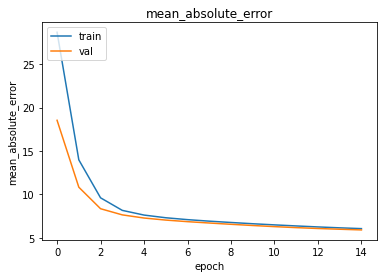

In [20]:
report_b.plot_keras_metric("mean_absolute_error")

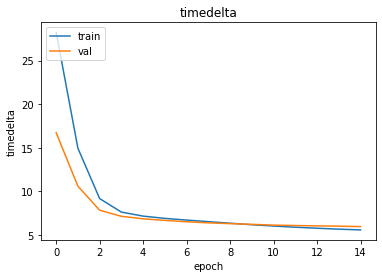

In [21]:
report_b.plot_keras_metric("timedelta")

### B. Holdout

While the model seems suffeciently good when we check the loss curves, since we changed how we split our data we wanted to further investigate how this would affect our predictions

#### Data Split A

In [80]:
test_rtdata = RetentionTimeDataset(data_source=TEST_DATAPATH_A,
                              seq_length=30, batch_size=32, test=True)

predictions_a = m1.predict(test_rtdata.test_data)
predictions_a = predictions_a.ravel()

test_targets_a = test_rtdata.get_split_targets(split="test")

In [81]:
report_a.calculate_r2(test_targets_a, predictions_a)

0.4144109592276479

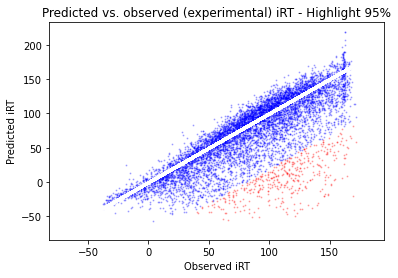

In [82]:
report_a.plot_highlight_data_portion(test_targets_a, predictions_a)

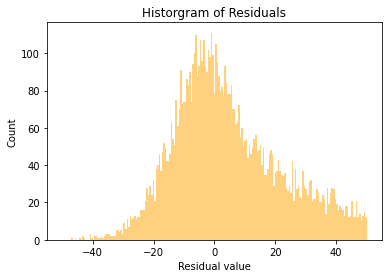

In [83]:
report_a.plot_residuals(test_targets_a, predictions_a, xrange=(-50, 50))

#### Data Split B

In [89]:
test_rtdata_b = RetentionTimeDataset(data_source=TEST_DATAPATH_B,
                              seq_length=30, batch_size=32, test=True)

predictions_b = m2.predict(test_rtdata_b.test_data)
predictions_b = predictions_b.ravel()

test_targets_b = test_rtdata_b.get_split_targets(split="test")

In [90]:
report_b.calculate_r2(test_targets_b, predictions_b)

-0.7411177579574866

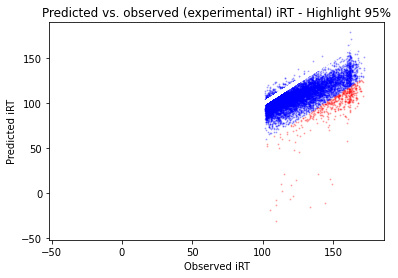

In [91]:
report_b.plot_highlight_data_portion(test_targets_b, predictions_b)

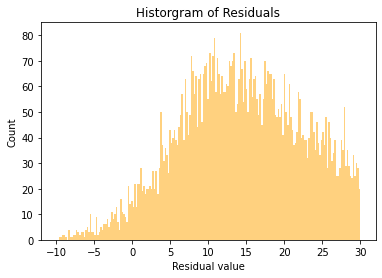

In [92]:
report_b.plot_residuals(test_targets_b, predictions_b, xrange=(-10, 30))

### C. Train/Test Splits

We analyze the differences between the training and test data to understand why we have such discrepancies between accuracy on Val and test data.

In [55]:
train_dataset_a = pd.read_csv(TRAIN_DATAPATH_A)
train_dataset_a.describe()

,irt,seq_len
count,31778.000000,31778.000000
mean,57.636939,11.667946
std,44.707751,2.924570
min,-36.890830,7.000000
25%,21.924017,9.000000
50%,55.737805,11.000000
75%,90.146778,14.000000
max,171.850147,17.000000


In [54]:
test_dataset_a = pd.read_csv(TEST_DATAPATH_A)
test_dataset_a.describe()

,irt,seq_len
count,8222.000000,8222.000000
mean,82.981177,21.441863
std,45.119653,3.505564
min,-37.397545,18.000000
25%,51.023020,19.000000
50%,86.041729,20.000000
75%,117.041110,23.000000
max,172.007471,40.000000


In [56]:
train_dataset_b = pd.read_csv(TRAIN_DATAPATH_B)
train_dataset_b.describe()

,irt,seq_len
count,31232.000000,31232.000000
mean,44.922545,13.025134
std,33.907428,4.737573
min,-37.397545,7.000000
25%,17.815422,9.000000
50%,47.004431,12.000000
75%,73.646519,16.000000
max,101.999119,40.000000


In [57]:
test_dataset_b = pd.read_csv(TEST_DATAPATH_B)
test_dataset_b.describe()

,irt,seq_len
count,8768.000000,8768.000000
mean,126.692173,15.998859
std,17.762008,5.180752
min,102.002341,7.000000
25%,111.688477,12.000000
50%,123.381815,15.000000
75%,139.040436,19.000000
max,172.007471,40.000000


## 3. Conclusion



While We didn't change anything in the model here we wanted to highlight that data splits also makes a difference. We Can see this in our predictions and how heavily skewed it is towards the training data.

#### Split A:

When we analyze our data you can see that in Split A data were split in such a way that shorter peptides are in training and longer peptides are in test which makes it harder for the model to predict unseen peptides with much longer sequences.


#### Split B:

Here we split our data based on iRT values where we have the peptides with lower iRTs in the training and ones with higher iRTs in the testing dataset.

What we want to highlight here is that even when we split the data on features (eg. peptide length) other than the feature which we predict (iRT), it can affect our results also.
That's why when splitting data we should ensure that our train data are homogenous and include all different type of classes we have and not favoring one class over another.